# Notebook for creating muscle images using Thad's model

Meant as a check on the 1D signal extraction process

## Imports

In [1]:
import muscle_model as mm
import os
import h5py
import cPickle
import cv2 

import numpy as np
import matplotlib.pyplot as plt

## Load extracted data

In [2]:
# path to fly we want to analyze
root_path = '/media/sam/SamData/FlyDB'
fly_num = 54

folder = 'Fly%04d' %(fly_num)
# subfolder = 'code_result'

# which side to look at
side = 'left'

In [3]:
# # load my dict containing the different data types
# data_path = os.path.join(root_path, folder, 'combined_dict.hdf5')
# data_dict = dict()

# with h5py.File(data_path, 'r') as h5f:
#     for key in h5f.keys():
#         data_dict[key] = h5f[key][:]

In [4]:
# load just the extracted muscle signals
signals_path = os.path.join(root_path, folder, 'ca_camera_%s_model_fits.hdf5'%(side))
data_dict = dict()

with h5py.File(signals_path, 'r') as h5f:
    for key in h5f.keys():
        print(key)
        data_dict[key] = h5f[key][:]

b1
b2
b3
bkg
hg1
hg2
hg3
hg4
i1
i2
iii1
iii24
iii3
nm
pr
t
tpd


## Load images

In [5]:
# load images
img_path = os.path.join(root_path, folder, 'ca_camera_%s.hdf5'%(side))

with h5py.File(img_path, 'r') as f:
    imgs = f['cam_imgs'][:]
    tstamps = f['cam_tstamps'][:]
    

## Load 'model' array

In [6]:
# this is stored in 'muscle_model', so need to get path to it
from planotaxis_scratch_base_fns import get_local_folder

scratch_dir = get_local_folder()
parent_dir = os.path.normpath(os.path.join(scratch_dir, '..', '..'))

unmixing_filters = os.path.join(parent_dir, 'muscle_model', 'unmixing_filters', 
                                'NA_0.45_200mm_Tube_FN1', 'flatened_model.hdf5')

In [8]:
# also need to get info on genotype so we have the correct list of muscles
genotype_fn = os.path.join(root_path, folder, 'fly_genotype.txt')
if os.path.exists(genotype_fn):
    with open(genotype_fn,'rt') as f:
        genotype_str = f.readlines()

    # just get the first line if it's a list
    if isinstance(genotype_str, list):
        genotype_str = genotype_str[0]

else:
    genotype_str = 'R22H05'
    
# check for muscle driver name
if 'R39E01' in genotype_str:
    profile_fn = 'GMR39E01'
elif 'R22H05' in genotype_str: 
    profile_fn = 'GMR22H05'
else:
    profile_fn = 'default'

# load profile pickle file
profile_fn += '.cpkl'
model_path = os.path.join(parent_dir, 'planotaxis', 'models')
profile_path = os.path.join(model_path, 'thorax', 'profiles', profile_fn)

with open(profile_path, 'rb') as f:
    profile_data = cPickle.load(f)

# # check what we loaded?
# print(profile_data)

In [9]:
# load contents of model hdf5 file, using the profile muscles to pick the appropriate muscle keys
muscles = profile_data['selected_components']

with h5py.File(unmixing_filters,'r') as f:
    model_muscles = [np.array(f[muscle][:]) for muscle in muscles]


In [10]:
# # check understanding -- i think 'model_muscles' should be the blurred images
# m_ind = 1  # 0=b1, 1=b2, etc
# print(model_muscles[m_ind].shape)

# fig, ax = plt.subplots()

# ax.imshow(model_muscles[m_ind], cmap='gray')
# ax.axis('off')

# fig.tight_layout()

## Load reference frame

I think we'll need to know the transformation between the confocal frame and the experimental images, and I don't think I stored this

In [11]:
 def get_transform(self,other):
    """get transform into self from other frame"""
    A1 = np.hstack((self['A'],self['p'][:,np.newaxis]))
    A2 = np.hstack((other['A'],other['p'][:,np.newaxis]))
    A1 = np.vstack((A1,[0,0,1]))
    A2 = np.vstack((A2,[0,0,1]))
    return(np.dot(A1,np.linalg.inv(A2)))

In [12]:
def construct_frame_dict(e1, e2):
    """Make a dictionary containing refrence frame info"""
    frame = dict()
    
    frame['e1'] = e1
    frame['e2'] = e2
    
    frame['a2'] = e1[1]-e2[0]
    frame['a1'] = e2[1]-e2[0]
    frame['p'] = e2[0]

    # also get transformation matrices based on these vectors
    frame['A'] = np.vstack((frame['a1'], frame['a2'])).T
    frame['A_inv'] = np.linalg.inv(frame['A'])
    
    return frame

In [13]:
# confocal frame -- this can be hard-coded or loaded from outlines data 
outlines_path = os.path.join(model_path, 'thorax', 'outlines.cpkl')
with open(outlines_path,'rb') as f:
    outlines_data = cPickle.load(f)

confocal_frame = construct_frame_dict(outlines_data['e1'], outlines_data['e2'])

In [14]:
# print(confocal_frame)

In [17]:
# data frame -- this is obtained from the saved model_frame file
data_rframe_path = os.path.join(root_path, folder, 'ca_camera_%s_rframe_fits.cpkl'%(side))

with open(data_rframe_path, 'rb') as f:
    data_frame = cPickle.load(f)

# reshape the matrices if need be
data_frame['A'] = np.reshape(data_frame['A'],(2,2))
data_frame['A_inv'] = np.reshape(data_frame['A_inv'],(2,2))

In [18]:
print(data_frame)

{u'A': array([[ 118.94544325,   11.49659369],
       [   8.27109877, -181.5001801 ]]), u'ros_tstamps': 1675035588.8811264, u'a1': array([118.94544325,   8.27109877]), u'p': array([134.40677195, 239.77983815]), u'a2': array([  11.49659369, -181.5001801 ]), u'components': 'pr;tpd;nm;i1;iii3;i2;hg2;hg3;hg1;iii1;b1;b2;b3;iii24;hg4;bkg', u'A_inv': array([[ 0.00837035,  0.00053019],
       [ 0.00038144, -0.00548548]])}


In [19]:
# get transformation between confocal and data
data_to_confocal = get_transform(confocal_frame, data_frame)
confocal_to_data = get_transform(data_frame, confocal_frame)

## Warp model muscles into data space

In [20]:
# output shape for warped images
output_shape = np.shape(imgs[0])
# output_shape = imgs[0].shape[::-1]

In [21]:
# create new list of warped model muscles
# NB: semi-confusing variable names are to match with old code
output_shapes = [output_shape for muscle in muscles]
transforms = [confocal_to_data[:-1,:] for muscle in muscles]
# transforms = [data_to_confocal[:-1,:] for muscle in muscles]

model = map(cv2.warpAffine, model_muscles, transforms, output_shapes)


In [22]:
print(muscles)

['b1', 'b2', 'b3', 'pr', 'nm', 'i2', 'iii24', 'i1', 'tpd', 'iii1', 'iii3', 'hg2', 'hg3', 'hg1', 'hg4']


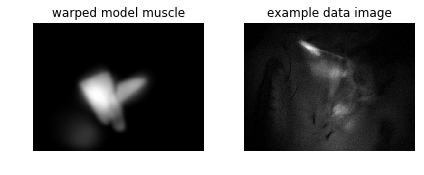

In [23]:
# test understanding here -- I think 'model' should contain confocal reference images mapped to data space
# m_ind = 0  # 0=b1, 1=b2, etc
# print(model[m_ind].shape)

fig, (ax1, ax2) = plt.subplots(1,2)

# test_im = np.zeros_like(model[0])
# for muscle_img in model[:6]:
#     test_im = cv2.add(test_im, muscle_img)
img_ind = 4238

test_im = model[0] + model[1] + model[2] + model[7] + model[-2]

# ax1.imshow(test_im.T, cmap='gray')
ax1.imshow(test_im.T, cmap='gray')
ax1.axis('off')
ax1.set_title('warped model muscle')

ax2.imshow(imgs[img_ind], cmap='gray')
ax2.axis('off')
ax2.set_title('example data image')

fig.tight_layout()

# --> this is confusing. warped image does not seem to match up to things
#      - may have something to do with "output_shape" since warpAffine takes the size arguments in a weird way
#      - if i switch the image output size and perform and flipud, things seem to match up

In [24]:
# add in an element for background
model_comb = [m for m in model]
muscles_comb = [m for m in muscles]

model_comb.append(np.ones_like(model[0]))
muscles_comb.append('bkg')

In [25]:
# do stacking as in viewer code
model_comb = np.vstack([muscle_im.T.ravel() for muscle_im in model_comb])
fit_pix_mask = np.ones_like(model_comb[0]) > 0


In [26]:
print(model_comb.shape)

(16, 97200)


## Do a test fit on a subset of images

In [86]:
# grab a set of images to do fits on -- following code adapted from 'viewer.py'
# img_ind = slice(4238-200, 4238+200)
# img_ind = slice(12105-200, 12105+200)
img_ind = slice(67830-400, 67830+400)
im_array = imgs[img_ind, :, :]
imshape = np.shape(im_array[0])
im_array = im_array.reshape((-1,imshape[0]*imshape[1]))


In [87]:
print(im_array.shape)

(800, 97200)


In [88]:
# do the matrix operation for extracting signals
model_inv = np.linalg.pinv(model_comb)

fits = np.dot(model_inv.T, im_array.T)
print(fits.shape)

(16, 800)


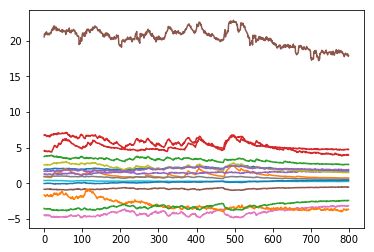

In [89]:
# general check to make sure we're getting signals
fig, ax = plt.subplots()

for ith in range(fits.shape[0]):
    ax.plot(fits[ith,:])

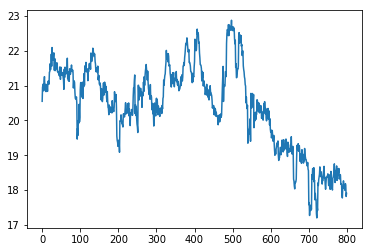

In [98]:
fig, ax = plt.subplots()


ax.plot(fits[-1,:])

Text(0.5,1,'i1')

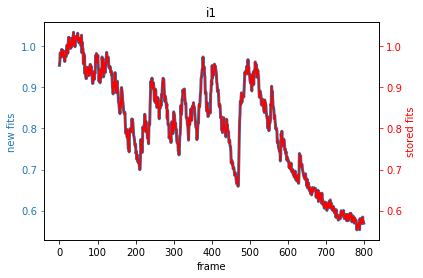

In [90]:
# check to see that the signals we get here match up with the ones extracted by the code
# going to look at i1
i1_fit_idx = muscles_comb.index('i1')

fig, ax = plt.subplots()
twin1 = ax.twinx()

p1, = ax.plot(fits[i1_fit_idx,:], linewidth=3)
p2, = twin1.plot(data_dict['i1'][img_ind], 'r-')

ax.set(xlabel="frame", ylabel="new fits")
twin1.set(ylabel="stored fits")

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())
ax.tick_params(axis='y', colors=p1.get_color())
twin1.tick_params(axis='y', colors=p2.get_color())

ax.set_title('i1')

Text(0.5,1,'iii1')

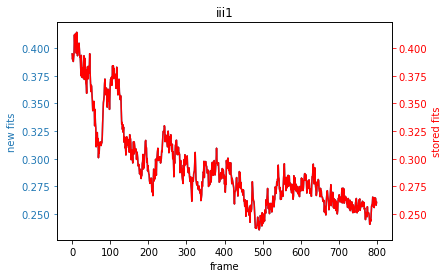

In [91]:
# test with another muscle
iii1_fit_idx = muscles_comb.index('iii1')

fig, ax = plt.subplots()
twin1 = ax.twinx()

p1, = ax.plot(fits[iii1_fit_idx,:])
p2, = twin1.plot(data_dict['iii1'][img_ind], 'r-')

ax.set(xlabel="frame", ylabel="new fits")
twin1.set(ylabel="stored fits")

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())
ax.tick_params(axis='y', colors=p1.get_color())
twin1.tick_params(axis='y', colors=p2.get_color())

ax.set_title('iii1')

## In parallel, look at what we would obtain from an ROI-based approach

In [92]:
def get_roi(img, frame_title='Select ROI (press enter when finished)', fullScreenFlag=False):
    """ user defined ROI """
    if fullScreenFlag:
        cv2.namedWindow(frame_title, cv2.WND_PROP_FULLSCREEN)
        cv2.setWindowProperty(frame_title, cv2.WND_PROP_FULLSCREEN,
                              cv2.WINDOW_FULLSCREEN)
    else:
        cv2.namedWindow(frame_title, cv2.WINDOW_NORMAL)

    fromCenter = False
    showCrosshair = False
    r = cv2.selectROI(frame_title, img, fromCenter, showCrosshair)
    # cv2.waitKey(0)
    cv2.destroyAllWindows()
    print(r)
    return r

In [93]:
# get image that we'll use for defining ROI region
roi_img = np.mean(imgs[::10], axis=0)
roi_img = np.flipud(roi_img)
roi_img = cv2.cvtColor(roi_img.astype(np.uint8),cv2.COLOR_GRAY2RGB)

# draw muscle outlines on this image
for m_name in muscles:
    # read out muscle outline in confocal frame
    muscle_outline = outlines_data[m_name]
    # convert to homogenous coordinates
    muscle_outline_h = np.vstack((muscle_outline, np.ones_like(muscle_outline[0,:])))
    # transform using affine transformation matrix
    muscle_outline_t = np.dot(confocal_to_data, muscle_outline_h)[:2,:]
    # convert to shape and dtype expected by opencv
    muscle_outline_pts = muscle_outline_t.copy().astype(np.int32)
    muscle_outline_pts = muscle_outline_pts.T.reshape(-1, 1, 2)
    
    # draw shape on image as polygon
    cv2.polylines(roi_img, [muscle_outline_pts], True, (0, 255, 255))
    

roi_img = np.flipud(roi_img)
# visualize ROI image
cv2.namedWindow('ROI image', cv2.WINDOW_NORMAL)
cv2.imshow('ROI image', roi_img)

k = cv2.waitKey(0) & 0xff
if k == 27:
    cv2.destroyAllWindows()

In [94]:
# define ROIs in the form (x, y, width, height)
GET_ROI_FLAG = False  # so we don't have to run this every time if we don't want to 

# which muscles should we grab ROIs for?
# NB: they should be ones for which we can define rectangles that only overlap a single muscle
roi_muscle_list = ['b1', 'b2', 'i1', 'iii1']

if GET_ROI_FLAG:
    # define a dictionary we can use to store various ROIs
    roi_dict = dict()
    manual_input_flag = False 
    
    # we have some cases we've already done this for 
    if (fly_num == 34) and (side == 'right'):
        roi_dict['i1'] = [197, 94, 20, 20]
        roi_dict['iii1'] = [165, 69, 10, 10]
        manual_input_flag = True
        
    elif (fly_num == 34) and side == 'left':
        roi_dict['i1'] = [178, 160, 8, 8]
        roi_dict['iii1'] = [141, 97, 12, 12]
        manual_input_flag = True
        
    else:
        # get things manually
        for m_name in roi_muscle_list:
            roi_dict[m_name] = get_roi(roi_img.copy(), 
                                       frame_title='Select ROI for **%s** (press enter when finished)' %(m_name))
            

In [95]:
# check that we got it right
CHECK_FLAG = True
if CHECK_FLAG:
    test_img = cv2.cvtColor(roi_img,cv2.COLOR_RGB2GRAY).copy()
    
    # draw the rectangles on each image
    for m_name in roi_dict.keys():
        if manual_input_flag:
            top_left = (roi_dict[m_name][0], roi_img.shape[0]-roi_dict[m_name][1])
            bottom_right = (roi_dict[m_name][0]+roi_dict[m_name][2], 
                            roi_img.shape[0]-(roi_dict[m_name][1] + roi_dict[m_name][3]))
        else:
            top_left = (roi_dict[m_name][0], roi_dict[m_name][1])
            bottom_right = (roi_dict[m_name][0]+roi_dict[m_name][2], 
                            roi_dict[m_name][1] + roi_dict[m_name][3])
    
        cv2.rectangle(test_img, top_left, bottom_right, (0,255,0),3)
    
    cv2.namedWindow('ROI check', cv2.WINDOW_NORMAL)
    cv2.imshow('ROI check', test_img)

    k = cv2.waitKey(0) & 0xff
    if k == 27:
        cv2.destroyAllWindows()

Text(0.5,1,'extra roi area test')

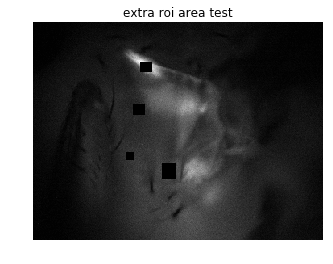

In [96]:
# get the average pixel value in the each roi over the range of the video
avg_pix_roi_dict = dict()  # initialize some storage

test_img_alt = imgs[1].copy()

# loop over muscle rois
for m_name in roi_dict.keys():
    
    row_idx = slice(int(roi_dict[m_name][1]), int(roi_dict[m_name][1])+int(roi_dict[m_name][3])) 
    col_idx = slice(int(roi_dict[m_name][0]), int(roi_dict[m_name][0])+int(roi_dict[m_name][2])) 

    imgs_roi = imgs[:, row_idx, col_idx]
    avg_pix_roi_dict[m_name] = np.mean(imgs_roi, axis=(1,2))
    
    # also block out test image area
    test_img_alt[row_idx,col_idx] = 0

# check test image
fig, ax = plt.subplots()

ax.imshow(test_img_alt, cmap='gray')
ax.axis('off')
ax.set_title('extra roi area test')

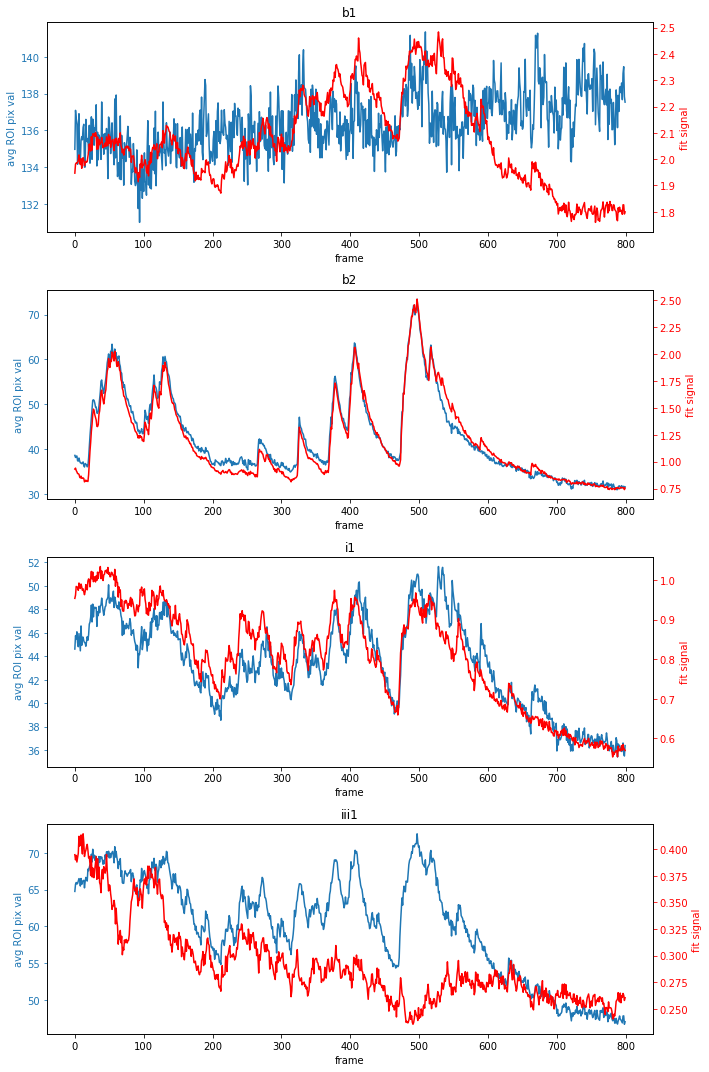

In [97]:
# look at the avg pixel value in the window we did a test fit over
fig, ax_list = plt.subplots(len(roi_muscle_list), 1, figsize=(10,15))
ax_list = ax_list.ravel()

for ith, m_name in enumerate(roi_muscle_list):
    # create axis twin for right side y axis
    twin = ax_list[ith].twinx()

    # plot roi method on left and fit signal on right
    p1, = ax_list[ith].plot(avg_pix_roi_dict[m_name][img_ind])
    p2, = twin.plot(fits[muscles_comb.index(m_name),:], 'r-')
    
    # set left and right axis labels
    ax_list[ith].set(xlabel="frame", ylabel="avg ROI pix val")
    twin.set(ylabel="fit signal")
    
    # color labels and ticks for left/right yaxes
    ax_list[ith].yaxis.label.set_color(p1.get_color())
    twin.yaxis.label.set_color(p2.get_color())
    ax_list[ith].tick_params(axis='y', colors=p1.get_color())
    twin.tick_params(axis='y', colors=p2.get_color())
    
    # set title to be muscle name
    ax_list[ith].set_title(m_name)

# make plot layout decent
plt.tight_layout()

## See what kind of images this produced

In [84]:
# try to get generated images by matrix operations and reshaping
# gen_img_vecs = np.dot(model_comb.T, fits)
gen_img_vecs = np.dot(fits.T, model_comb)

new_shape = (-1, imgs.shape[1], imgs.shape[2])
gen_imgs = gen_img_vecs.reshape(new_shape)

In [85]:
print(gen_img_vecs.shape)
print(gen_imgs.shape)

(400, 97200)
(400, 270, 360)


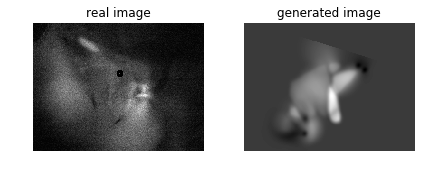

In [86]:
# do a quick visualization of this
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.imshow(imgs[img_ind][0], cmap='gray')
ax1.axis('off')
ax1.set_title('real image')

ax2.imshow(gen_imgs[0], cmap='gray')
ax2.axis('off')
ax2.set_title('generated image')

fig.tight_layout()
